<a href="https://colab.research.google.com/github/VenomCocytus/IMDB_Sentimental_Analysis_Python/blob/main/WL_Research_Projet_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis of IMDB Movie Reviews

Problem Statement:

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

Import necessary libraries

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
#print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
#download and import the nltk library for NLP
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

dataset download and decompression.


In [3]:
!    wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!    tar xfz aclImdb_v1.tar.gz

--2022-06-17 15:40:49--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.7MB/s    in 5.0s    

2022-06-17 15:40:54 (16.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]




this part of code allows us to transcribe all the data present in the train(pos and neg) folder as well as test(pos and neg) into a csv file labeled positive and negative for feelings.

In [4]:
import os
import pandas as pd
import numpy as np
labels = {'pos': 'positive', 'neg': 'negative'}
dataset = pd.DataFrame()
for directory in ('test', 'train'):
    for sentiment in ('pos', 'neg'):
        # Note: change the path name with your directory
        path =r'aclImdb/{}/{}'.format(directory, sentiment)             
       
        for review_file in os.listdir(path):
            with open(os.path.join(path, review_file), 'r', encoding='utf8') as input_file:
                review = input_file.read()
            dataset = dataset.append([[review, labels[sentiment]]],
                                     ignore_index=True)
dataset.columns = ['review', 'sentiment']
indices = dataset.index.tolist()
np.random.shuffle(indices)
indices = np.array(indices)
dataset = dataset.reindex(index=indices)
dataset.to_csv('IMDB Dataset.csv', index=False)




Import the training data to the dataset






In [5]:
 #importing the training data
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,Ha. without a doubt Tommy's the evil one here....,negative
1,I must admit that this is one of the few Lou C...,positive
2,This movie scared the crap out of me! I have t...,positive
3,Edward Montagne's Tattooed Stranger is suppose...,negative
4,Did HeidiJean really see this movie? A great C...,negative
5,1. The Largest Amount of Money Spent was on th...,negative
6,"Seriously, what is THIS? Hooper has made such ...",negative
7,John Carpenter's Halloween<br /><br />Is it th...,positive
8,Final Score (an average of various classic cin...,negative
9,I honestly had no idea that the Notorious B.I....,negative


explore the data analisys

In [6]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


Sentiment count

In [7]:
#sentiment count
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

Spliting the training dataset

In [8]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


one of the first steps in manipulating the text consists in deleting the stopwords which represent the fairly common words in the corpus and which do not bring any particular meaning to the latter

In [9]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

Removing html strips and noise text

In [10]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

Removing special characters

In [11]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

the process of stemming consists in representing words only in their canonical forms, for example verbs in the infinitive forms, for a singular masculine noun in order to retain only their textual meanings.

In [12]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

Removing stopwords.

In [13]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{"mightn't", 'her', 'while', 'off', "you'll", 'all', 'herself', 'it', 'more', "won't", 'each', 'so', 'down', "aren't", 'hers', "she's", 'haven', 'for', 'then', "doesn't", 'being', 'does', 'those', 'some', 'don', 'how', 've', 'won', 'your', "wouldn't", 'at', 'this', "wasn't", 'of', 'my', 'or', 'y', 'here', 'his', 'into', 'both', 'very', "hadn't", 's', 'after', 'aren', 'themselves', 'these', 'couldn', 'hasn', 'too', 'whom', "weren't", 'most', 'which', 'where', "didn't", 'm', 'mightn', 'isn', 'if', 'who', 'were', 'needn', 'their', 'as', "it's", "haven't", 'because', 'our', 'on', "shan't", 'when', 'shan', "mustn't", "isn't", 'and', 'did', 'an', 'weren', 'myself', "don't", 'they', 'himself', 'she', "should've", 'own', 'about', 'than', 'few', 'over', 'should', 'in', 'now', 'but', 'out', 'again', 'i', 'we', 'he', 'yours', 'why', "you'd", 'against', 'll', 'before', "you've", 'just', 't', 'a', 'nor', 'has', 'under', 'd', 'have', 'hadn', 'o', 'can', 'be', 'from', 'no', 'not', 'yourselves', 'to',

In [14]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'ha without doubt tommi evil one dont know whi reason littl kid horror movi tend come across littl butt munch sinc theyr kid wont die becaus theyr annoyingwellexcept asylum terror far betweenanyway onto movi cant find thi movi dvd sure buy chill classic dvd pack onli get metamorphosi dvd 15 also get 49 movi bargain pff ok im done advertis cheesi movi let say thi movi aint worth 15 buck ownso chemist scientist yeah caus chemist scientist look handsom thi guy play peter tri come serum stop deterior bodi colleg work want pull plug hi project tri becaus thi horror movi suck start incred long transform sequenc take nearli 34 movieto pad movi get relationship woman ha son wa never marri scandal cours tommi one irrit charactersno take back irrit charact far wors old crippl guy want take peter work gloat hospit right even old crippl still villainso see peter start randomli kill peopl vision ha realiz one decid kill everyon hi path get back normal howev end end deevolv lizard yeah know dont ask

In [15]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'dont get wrong love bad movi ador bad movi troll 2 ouch pain mano hand fate watch torgo go guru mad monk traffic nois mediev background ok clear thi one film wa quit obvious tri someth better didnt make whi well would easi blame plot heh weve seen wors werent mani hole heh know lot origin neednt kill film effect arent bad complet ignor last scene monster ok truck quit menac go wrong well id love blame chri moyl lookalik harley comedi horror difficult mix well bad comedi horror even wors problem loath thi guy moment stuck hi head liter continu bate overli meek adam becom annoy annoy lose belief mildest peopl wouldnt react push move car door thought wa monster bit director wa meant troubl convinc us whi bad movi fun well great fun poke hole laugh script howler etc thi film doesnt make covet categori worst movi becaus bad due annoy nuff said dont bother go watch anyth els youll better person promis fade chant torgo torgo torgo'

Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [16]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6213758)
BOW_cv_test: (10000, 6213758)


Term Frequency-Inverse Document Frequency model (TFIDF)

It is used to convert text documents to matrix of tfidf features.

In [17]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6213758)
Tfidf_test: (10000, 6213758)


Labeling the sentiment text

In [18]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


Split the sentiment tdata

In [19]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


Build a model.

Let us build logistic regression model for both bag of words and tfidf features

In [20]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


Logistic regression model performane on test dataset

In [21]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


Accuracy of the model

In [22]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7459
lr_tfidf_score : 0.7453


In [23]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      5010
    Negative       0.75      0.75      0.75      4990

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.75      0.75      5010
    Negative       0.75      0.74      0.74      4990

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [24]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3721 1269]
 [1272 3738]]
[[3675 1315]
 [1232 3778]]


In [25]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [26]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [27]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5101
svm_tfidf_score : 0.499


In [28]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.99      0.02      0.04      5010
    Negative       0.50      1.00      0.67      4990

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00      5010
    Negative       0.50      1.00      0.67      4990

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



In [29]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4989    1]
 [4898  112]]
[[4990    0]
 [5010    0]]


In [30]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [31]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [32]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.746
mnb_tfidf_score : 0.7452


In [33]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.75      0.75      5010
    Negative       0.75      0.74      0.74      4990

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.75      0.75      5010
    Negative       0.75      0.74      0.74      4990

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [34]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3690 1300]
 [1240 3770]]
[[3700 1290]
 [1258 3752]]


<function matplotlib.pyplot.show>

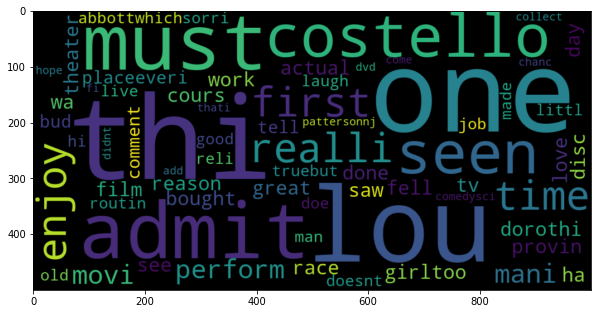

In [35]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show>

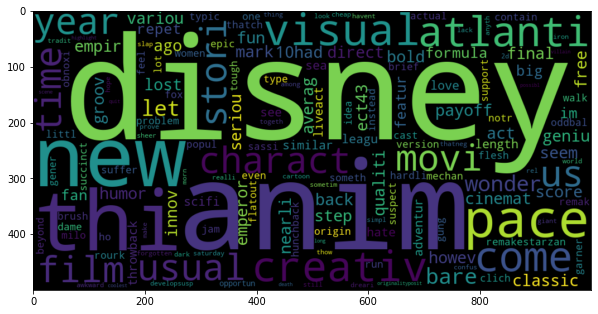

In [36]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

**MODEL BASED WITH THE CNNs**

In this part,we are going to buil a model based with the CNNs architecture

In [37]:
import tensorflow as tf   #load library
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.layers import TextVectorization
import string
import re


Load the data: IMDB movie review sentiment classification

Let's download the data and inspect its structure.

In [38]:
!    wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!    tar xfz aclImdb_v1.tar.gz

--2022-06-17 15:52:00--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  22.1MB/s    in 4.9s    

2022-06-17 15:52:05 (16.5 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [39]:
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


Let's use it to generate the training, validation, and test datasets. 

The validation and training datasets are generated from two subsets of the train directory, with 20% of samples going to the validation dataset and 80% going to the training dataset.

In [40]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 75000 files belonging to 3 classes.
Using 60000 files for training.
Found 75000 files belonging to 3 classes.
Using 15000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 1875
Number of batches in raw_val_ds: 469
Number of batches in raw_test_ds: 782


Let's preview a few samples:




In [41]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'SPOILERS: We sit through ten minutes of AWFUL clich\xc3\xa9d dialog at the beginning from two completely unoriginal characters with bad twangs (ripped off from Kalifornia and Natural Born Killers - there isn\'t an original thing about these two) and you\'re going "either they\'re about to kill everyone in the diner or already have" and lo and behold guess what happens.<br /><br />I can\'t stand all the Tarantino wannabes out there and this guy is one of the worst. I got maybe 25-30 minutes into the thing when I just couldn\'t take it and stopped watching. Miner\'s really bad acting was unbearable - I couldn\'t take it. That, and the terrible script. After reading some of these comments I see there was a big twist - well guess what? No one cares. When you create completely uninteresting, unoriginal and unlikeable character like these two clich\xc3\xa9s, no one cares what big "twist" may have happened. I hope this is the end of these types of movies.'
2
b'This movie is horrible- in a \



Prepare the data


In particular, we remove <br /> tags.

In [42]:
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500


In [43]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)


In [44]:
text_ds = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(text_ds)

In [45]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [46]:

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [47]:
epochs = 3

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
1875/1875 [==============================] - 398s 212ms/step - loss: -332798361600.0000 - accuracy: 0.1665 - val_loss: -1776897753088.0000 - val_accuracy: 0.1677
Epoch 2/3
1875/1875 [==============================] - 366s 195ms/step - loss: -12783137587200.0000 - accuracy: 0.1664 - val_loss: -32150023831552.0000 - val_accuracy: 0.1677
Epoch 3/3
1875/1875 [==============================] - 350s 187ms/step - loss: -85666587213824.0000 - accuracy: 0.1664 - val_loss: -155913805627392.0000 - val_accuracy: 0.1677


In [48]:
model.evaluate(test_ds)

782/782 [==============================] - 35s 44ms/step - loss: 157724889317376.0000 - accuracy: 0.5000


[157724889317376.0, 0.5]

Bidirectional LSTM on IMDB

Train a 2-layer bidirectional LSTM on the IMDB movie review sentiment classification dataset.

In [49]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


In [50]:
max_features = 20000 # Only consider the top 20k words
max_len = 250        # Only consider the first 200 words of each movie review


Load the IMDB movie review sentiment data

In [51]:
inputs = keras.Input(shape=(None,), dtype = "int32")  # Input for variable-length sequences of integers
x = layers.Embedding(max_features, 128)(inputs)         # Embed each integer in a 128-dimensional vector
#Add two bidirectionnal LTMS
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
                                                 # add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable params: 2,757,761
Non-tra

Train and evaluate the model

In [52]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=max_len)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [53]:
model.compile("adam", "binary_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train,batch_size=32,epochs=2,validation_data=(x_val,y_val))

Epoch 1/2
782/782 [==============================] - 657s 829ms/step - loss: 0.3789 - accuracy: 0.8330 - val_loss: 0.3369 - val_accuracy: 0.8624
Epoch 2/2
782/782 [==============================] - 659s 843ms/step - loss: 0.1986 - accuracy: 0.9269 - val_loss: 0.4690 - val_accuracy: 0.8096


load library

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Implement a Transformer block as a layer

In [55]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Implement embedding layer.


Two seperate embedding layers, one for tokens, one for token index (positions).

In [56]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Download and prepare dataset

In [57]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


Create classifier model using transformer layer


Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [58]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Train and evaluate the model

In [59]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 127s 160ms/step - loss: 0.3830 - accuracy: 0.8196 - val_loss: 0.2897 - val_accuracy: 0.8782
Epoch 2/2
782/782 [==============================] - 124s 159ms/step - loss: 0.2008 - accuracy: 0.9225 - val_loss: 0.3262 - val_accuracy: 0.8641


3- MODEL BASED WITH CNN architecture

In [60]:
# Importing libraries
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# Our dictionary will contain only of the top 7000 words appearing most frequently
top_words = 7000
# Now we split our data-set into training and test data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# Looking at the nature of training data
print(X_train[0])
print(y_train[0])
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
Shape of training data: 
(25000,)
(25000,)
Shape of test data

As we see, our dataset consists of 25,000 training samples and 25,000 test samples. Every data is a vector of text indexed within the limit of top words which we defined as 7000 above.


Now, we pad our input data so the kernel filter and stride can fit in input well. We limit the padding of each review input to 450 words. Keras provides us with function to pad sequences. So, we use it on our reviews.

In [61]:
# Padding the data samples to a maximum review length in words
max_words = 450
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

The model first consists of embedding layer in which we will find the embeddings of the top 7000 words into a 32 dimensional embedding and the input we can take in is defined as the maximum length of a review allowed.


Then, we add the convolutional layer and max-pooling layer. Finally, we flatten those matrices into vectors and add dense layers(basically scale,rotating and transform the vector by multiplying Matrix and vector).

In [62]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 450, 32)           224000    
                                                                 
 conv1d_2 (Conv1D)           (None, 450, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 225, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense_6 (Dense)             (None, 250)               1800250   
                                                                 
 dense_7 (Dense)             (None, 1)                 251       
                                                      

Now, we will fit our training data and define the the epochs(number of passes through dataset) and batch size(nunmber of samples processed before updating the model) for our learning model.

Batch size is kept greater than or equal to 1 and less than the number of samples in training data.

In [63]:
# Fitting the data onto model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2
196/196 - 29s - loss: 0.4727 - accuracy: 0.7384 - val_loss: 0.2897 - val_accuracy: 0.8782 - 29s/epoch - 149ms/step
Epoch 2/2
196/196 - 27s - loss: 0.2138 - accuracy: 0.9175 - val_loss: 0.2757 - val_accuracy: 0.8840 - 27s/epoch - 140ms/step
Accuracy: 88.40%


We were able to achieve an accuracy of 88.6% over IMDB movie reviews’ test data.

We can improve our CNN model by adding more layers. It is always preferred to have more(dense) layers than to have wide layers of less number.
But, we must take care to not overfit the data and for that we can try using various regularization methods.